In [1]:
%load_ext autoreload
%autoreload 2
import netCDF4
import xarray as xr
from pathlib import Path
from hmpai.pytorch.models import *
from hmpai.training import split_data_on_participants, split_participants
from hmpai.pytorch.training import train, validate, calculate_class_weights, train_and_test, k_fold_cross_validate, test, calculate_global_class_weights
from hmpai.pytorch.utilities import DEVICE, set_global_seed, get_summary_str, save_model, load_model
from hmpai.pytorch.generators import SAT1Dataset, MultiXArrayDataset, MultiXArrayProbaDataset
from hmpai.data import SAT1_STAGES_ACCURACY, SAT_CLASSES_ACCURACY
# from hmpai.visualization import plot_confusion_matrix
from hmpai.pytorch.normalization import *
from torchinfo import summary
from hmpai.utilities import print_results, CHANNELS_2D, AR_SAT1_CHANNELS, get_masking_index
from torch.utils.data import DataLoader
# from braindecode.models.eegconformer import EEGConformer
from mne.io import read_info
import os
DATA_PATH = Path(os.getenv("DATA_PATH"))
from hmpai.visualization import *
from hmpai.behaviour.sat2 import read_behavioural_info, SAT2_SPLITS, merge_data
from hmpai.pytorch.mamba import *

In [6]:
set_global_seed(42)

data_paths = [DATA_PATH / "prp/stage_data_250hz_combined.nc"]

# train_percentage=100 makes test and val 100 as well
splits = split_participants(data_paths, train_percentage=60)
labels = ["negative", "t1_1", "t1_2", "t1_3", "t1_4", "t2_1", "t2_2", "t2_3"]
# info_to_keep = ['event_name', 'participant', 'epochs', 'rt'] #TODO: Might not be present
info_to_keep = ['rt', 'condition','trial_index']
whole_epoch = True
# Change to short for testing on short SOA
subset_cond = ('condition', 'equal', 'short')
add_negative = True
skip_samples = 0 # 62
cut_samples = 0 # 63
add_pe = True

In [7]:
norm_fn = norm_mad_zscore
train_data = MultiXArrayProbaDataset(
    data_paths,
    participants_to_keep=splits[0],
    normalization_fn=norm_fn,
    whole_epoch=whole_epoch,
    labels=labels,
    info_to_keep=info_to_keep,
    subset_cond=subset_cond,
    add_negative=add_negative,
    # transform=Compose([StartJitterTransform(62, 1.0), EndJitterTransform(63, 1.0)]),
    skip_samples=skip_samples,
    cut_samples=cut_samples,
    add_pe=add_pe,
)
norm_vars = get_norm_vars_from_global_statistics(train_data.statistics, norm_fn)
class_weights = train_data.statistics["class_weights"]
test_data = MultiXArrayProbaDataset(
    data_paths,
    participants_to_keep=splits[1],
    normalization_fn=norm_fn,
    norm_vars=norm_vars,
    whole_epoch=whole_epoch,
    labels=labels,
    info_to_keep=info_to_keep,
    subset_cond=subset_cond,
    add_negative=add_negative,
    skip_samples=skip_samples,
    cut_samples=cut_samples,
    add_pe=add_pe,
)
val_data = MultiXArrayProbaDataset(
    data_paths,
    participants_to_keep=splits[2],
    normalization_fn=norm_fn,
    norm_vars=norm_vars,
    whole_epoch=whole_epoch,
    labels=labels,
    info_to_keep=info_to_keep,
    subset_cond=subset_cond,
    add_negative=add_negative,
    skip_samples=skip_samples,
    cut_samples=cut_samples,
    add_pe=add_pe,
)

In [12]:
# Loader for eventual batch-wise analysis
test_loader = DataLoader(
    test_data, batch_size=128, shuffle=True, num_workers=0, pin_memory=True
)

In [8]:
chk_path = Path("../logs/20250129-170144/checkpoint.pt")
checkpoint = load_model(chk_path)
config = {
    "n_channels": 64,
    "n_classes": len(labels),
    "n_mamba_layers": 5,
    "use_pointconv_fe": True,
    "spatial_feature_dim": 128,
    "use_conv": True,
    "conv_kernel_sizes": [3],
    "conv_in_channels": [128],
    "conv_out_channels": [256],
    "conv_concat": True,
    "use_pos_enc": True,
}
model = build_mamba(config)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(DEVICE)
model.eval();

In [16]:
labels

['negative', 't1_1', 't1_2', 't1_3', 't1_4', 't2_1', 't2_2', 't2_3']

1401


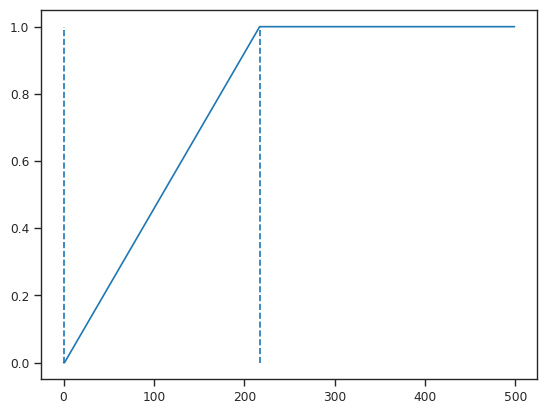

{'rt': np.float64(0.8515625), 'condition': np.str_('short'), 'trial_index': np.float64(521.0)}


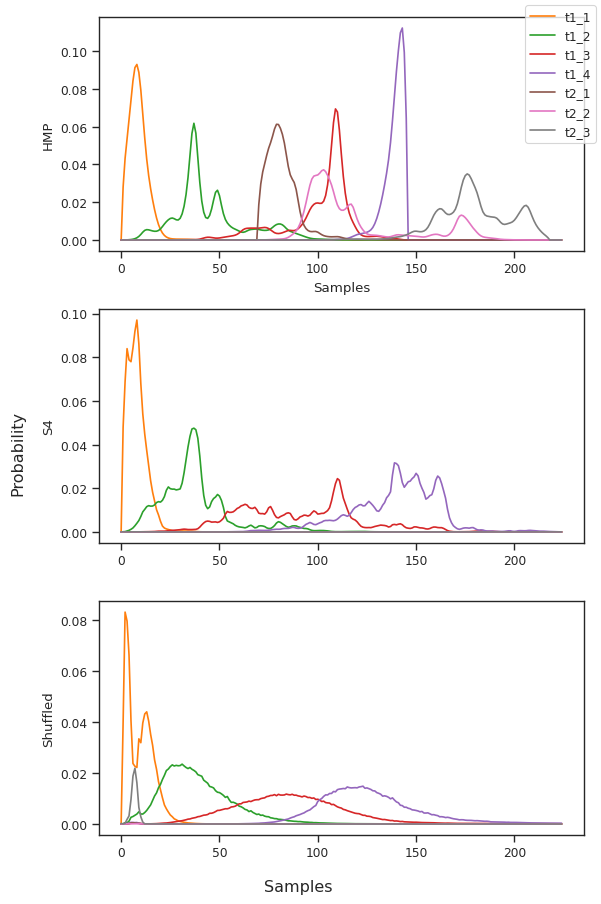

1961


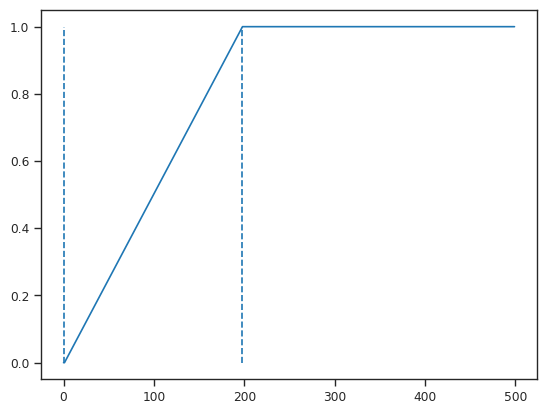

{'rt': np.float64(0.77734375), 'condition': np.str_('short'), 'trial_index': np.float64(584.0)}


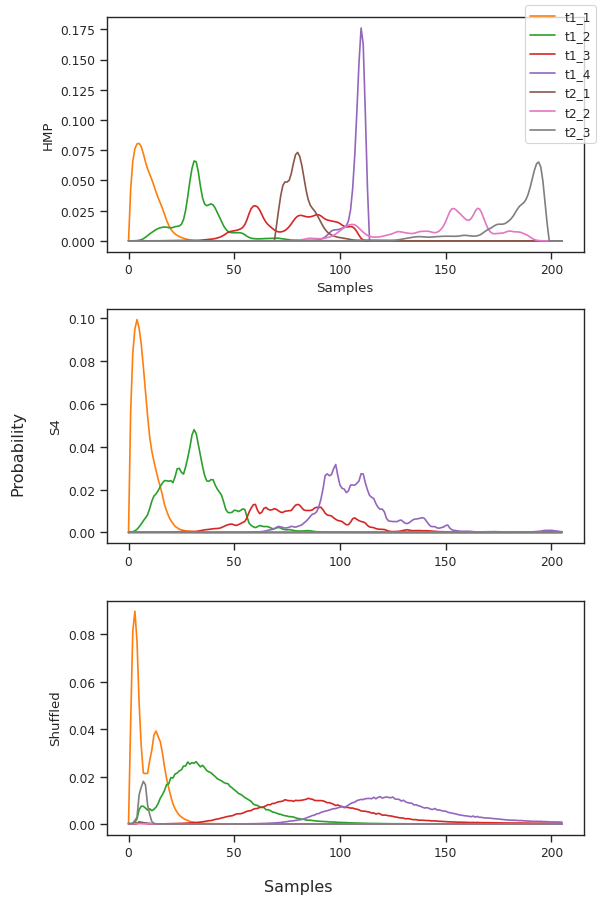

964


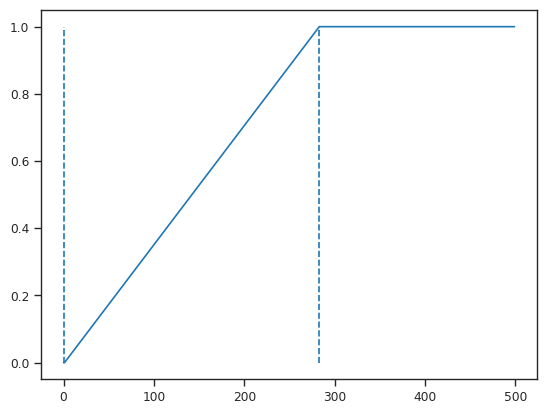

{'rt': np.float64(1.115234375), 'condition': np.str_('short'), 'trial_index': np.float64(791.0)}


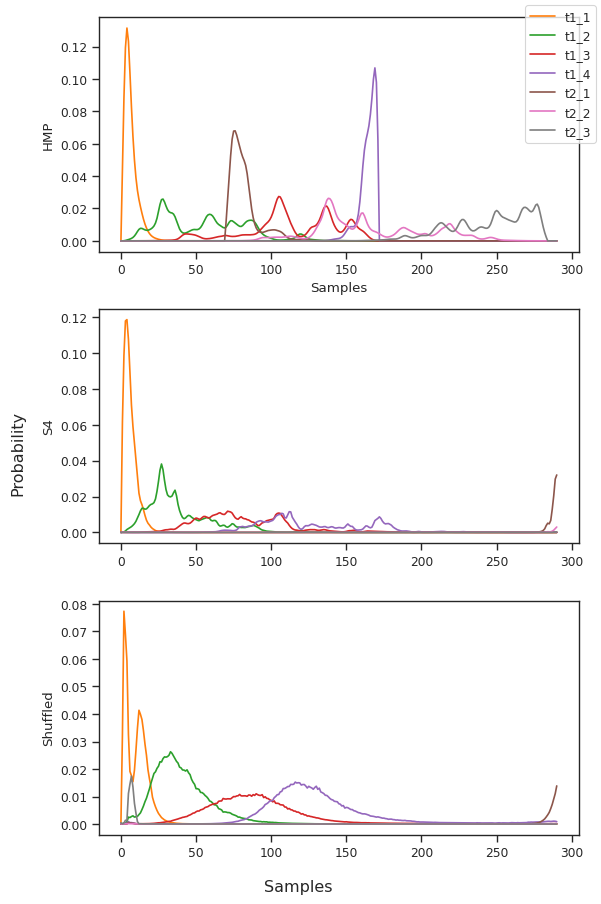

1778


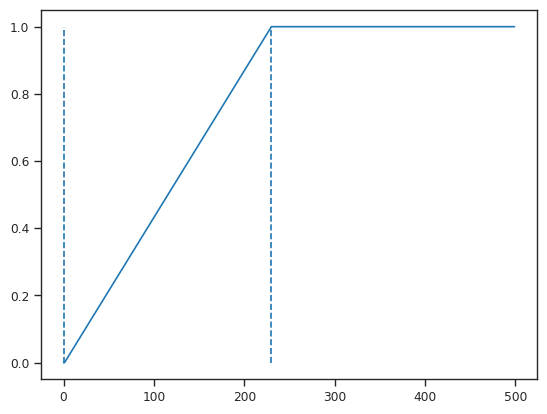

{'rt': np.float64(0.90625), 'condition': np.str_('short'), 'trial_index': np.float64(133.0)}


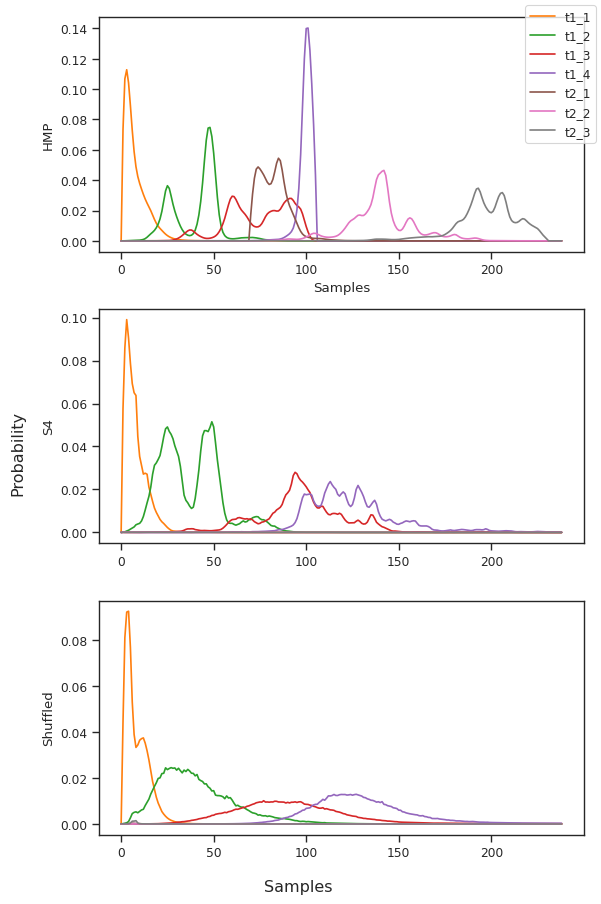

2000


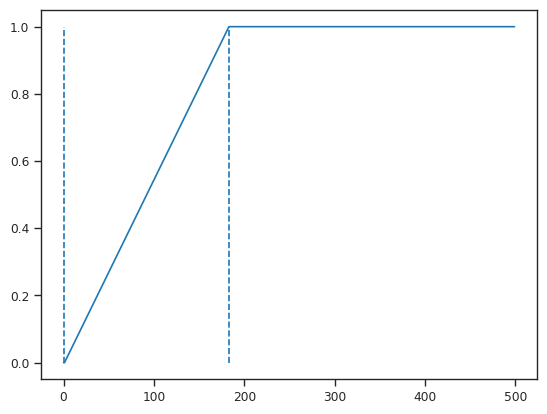

{'rt': np.float64(0.716796875), 'condition': np.str_('short'), 'trial_index': np.float64(673.0)}


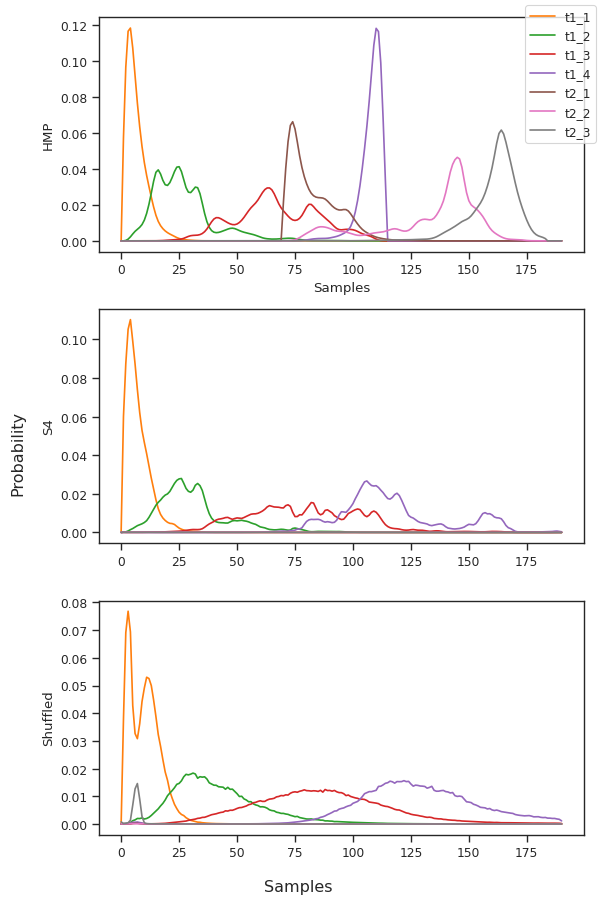

1974


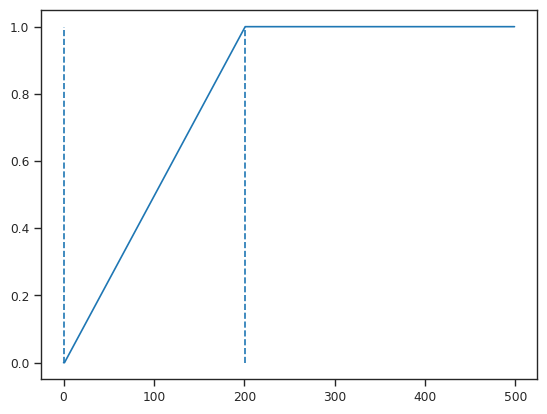

{'rt': np.float64(0.7890625), 'condition': np.str_('short'), 'trial_index': np.float64(608.0)}


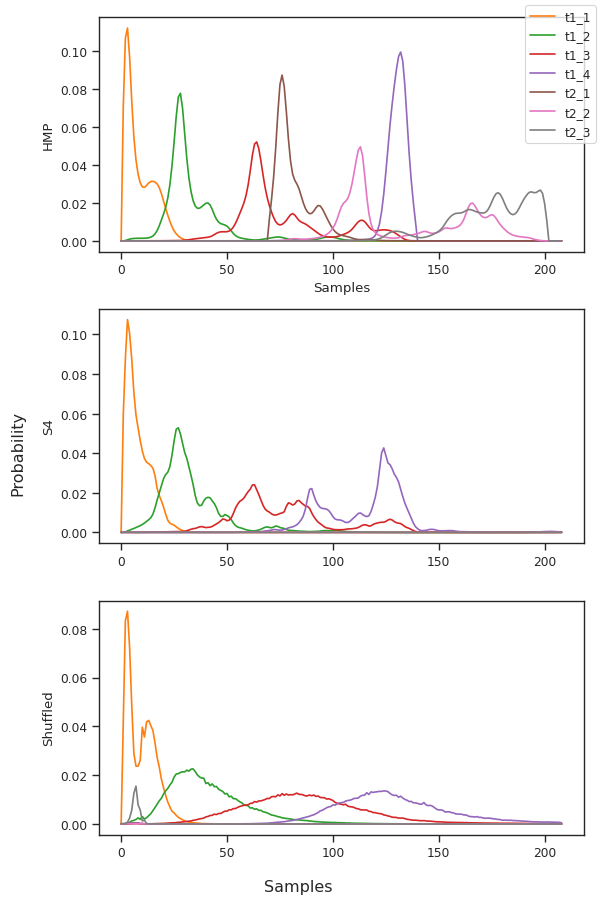

315


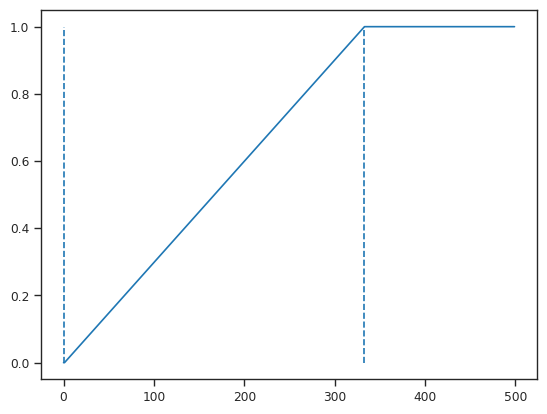

{'rt': np.float64(1.318359375), 'condition': np.str_('short'), 'trial_index': np.float64(716.0)}


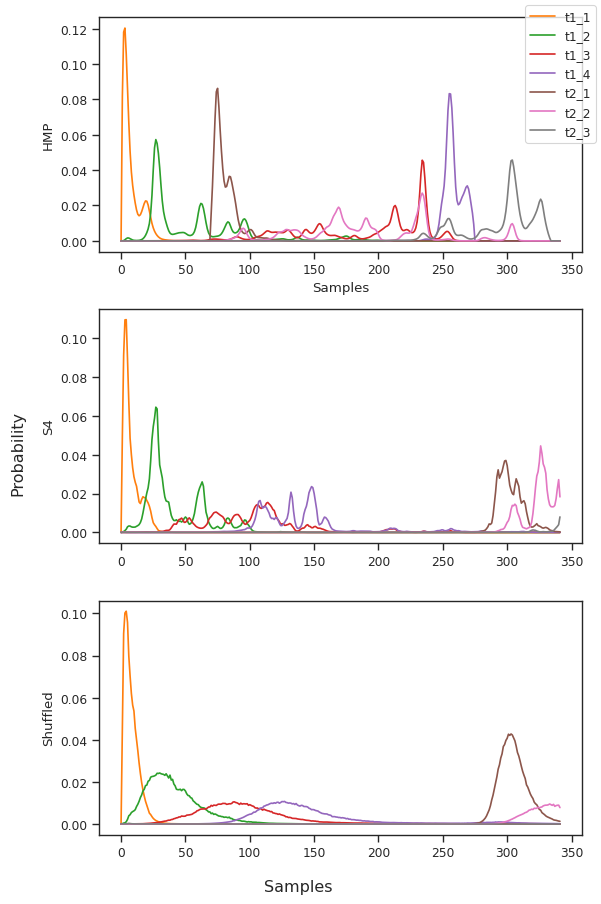

255


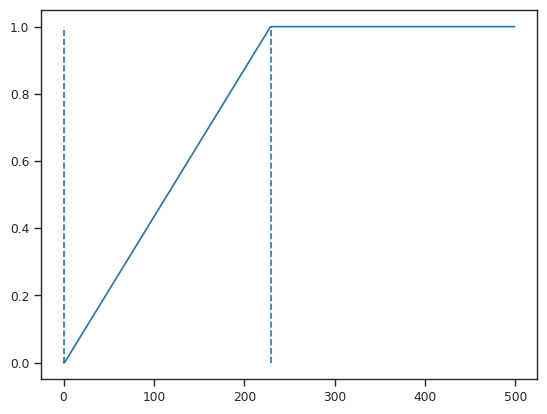

{'rt': np.float64(0.900390625), 'condition': np.str_('short'), 'trial_index': np.float64(581.0)}


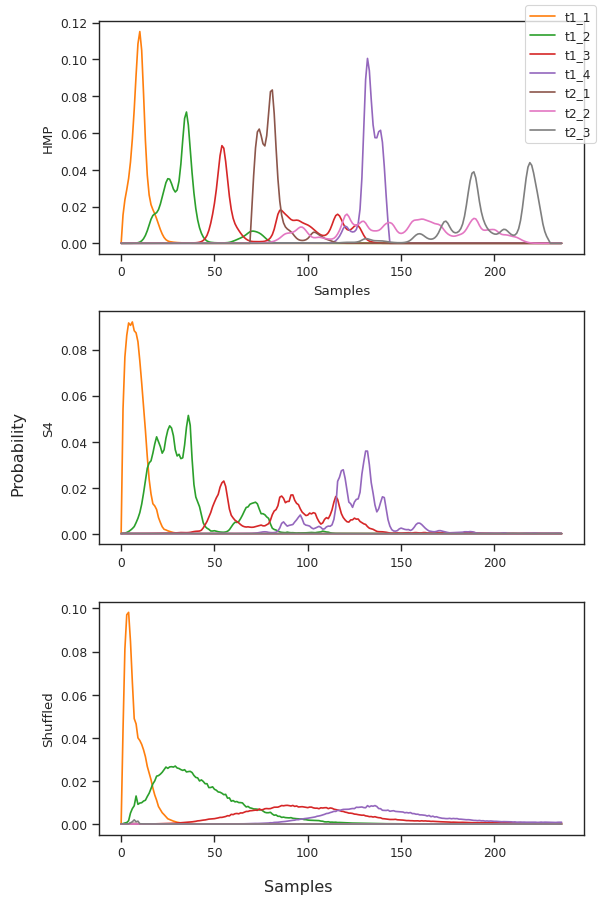

396


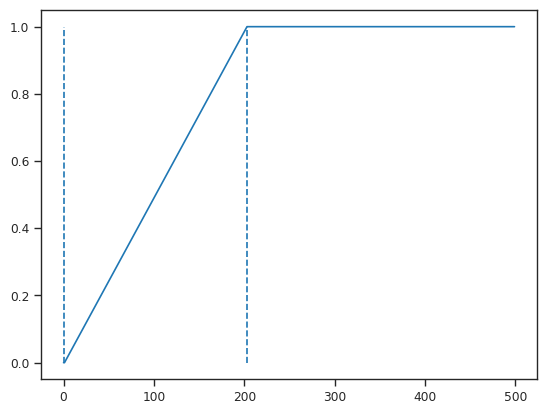

{'rt': np.float64(0.794921875), 'condition': np.str_('short'), 'trial_index': np.float64(895.0)}


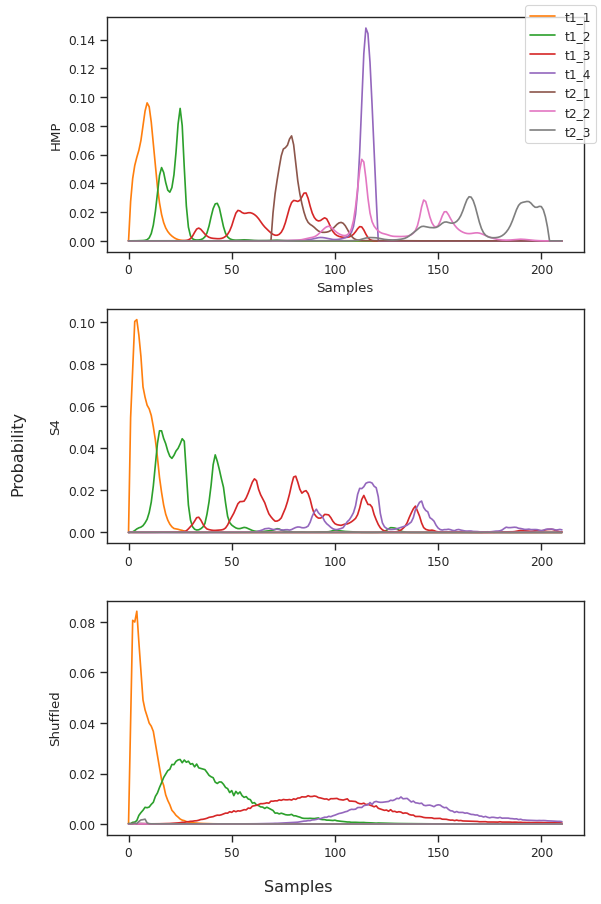

1853


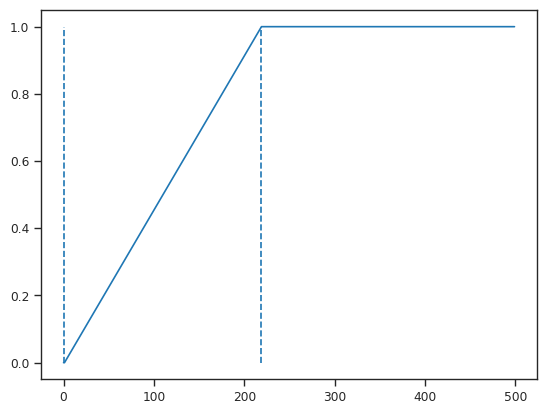

{'rt': np.float64(0.857421875), 'condition': np.str_('short'), 'trial_index': np.float64(321.0)}


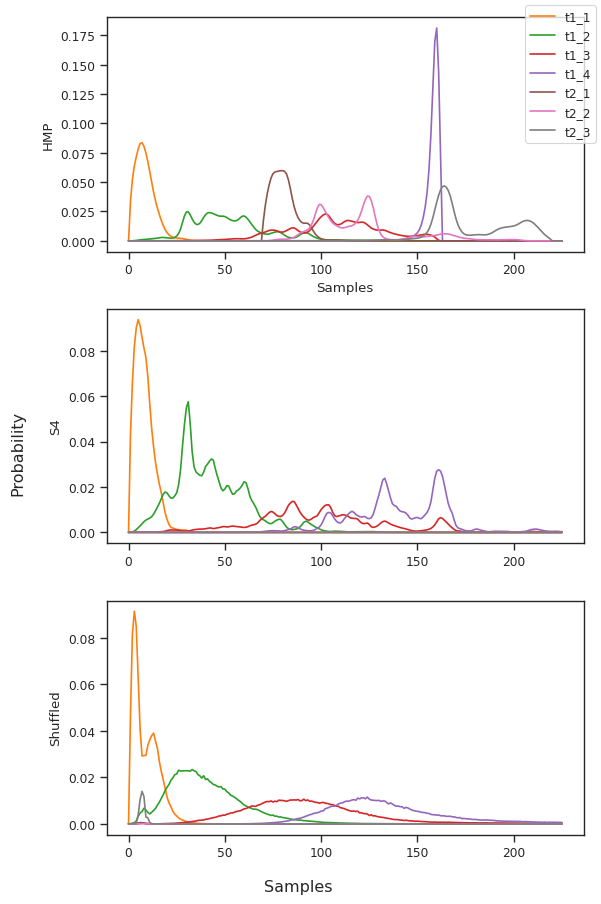

In [9]:
for i in torch.randint(len(test_data), (10,)):
    print(i.item())
    display_trial(model, test_data, None, i, labels)

In [ ]:
display_trial(model, test_data, behaviour_sat2, 15616, labels)